# Project 1 - Store Sales Time Series Forecasting - Riyaldo Rio Parakasi

Semangat mengerjakan projectnya!

### Objective
- Memahami data yang digunakan, bagaimana melihat data, melakukan visualisasi hingga memahami karakteristik time series data.
- Melakukan process data, seperti cleaning, transformasi, hingga feature engineering.
- Melakukan pemodelan menggunakan ARIMA dan LSTM.
- Melakukan evaluasi model yang telah dibuat.
- Menarik kesimpulan dari hasil analisis yang telah dilakukan.

### Terms
- `ARIMA` : Autoregressive Integrated Moving Average, model statistik yang digunakan dalam analisis data time series.
- `LSTM` : Long Short Term Memory, model neural network yang digunakan dalam analisis data time series.
- `Time Series` : Data yang terurut berdasarkan waktu.
- `Forecasting` : Proses memprediksi nilai di masa depan berdasarkan data masa lalu.


### Penjelasan singkat tentang data

you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

## Import All Library

In [4]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

## Prepare the Data

In [5]:
df_train = pd.read_csv('store5.csv')
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [9]:
# Check for missing values
df_train.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

In [10]:
# Check total value all family
df_train['family'].value_counts()

AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY        

In [11]:
# Menghapus selain kolom family dan sales

# hapus kolom id dan store_nbr
df_train.drop(['id', 'store_nbr','onpromotion','dcoilwtico'], axis=1, inplace=True)
df_copy = df_train.copy()
# Mengubah tipe data kolom date menjadi datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# Mengurutkan data berdasarkan tanggal
df_train = df_train.set_index('date')
df_train

,family,sales
date,,
2013-01-01,AUTOMOTIVE,0.000
2013-01-01,BABY CARE,0.000
2013-01-01,BEAUTY,0.000
2013-01-01,BEVERAGES,0.000
2013-01-01,BOOKS,0.000
...,...,...
2017-08-15,POULTRY,241.011
2017-08-15,PREPARED FOODS,52.121
2017-08-15,PRODUCE,1357.823


## EDA (Exploratory Data Analysis)

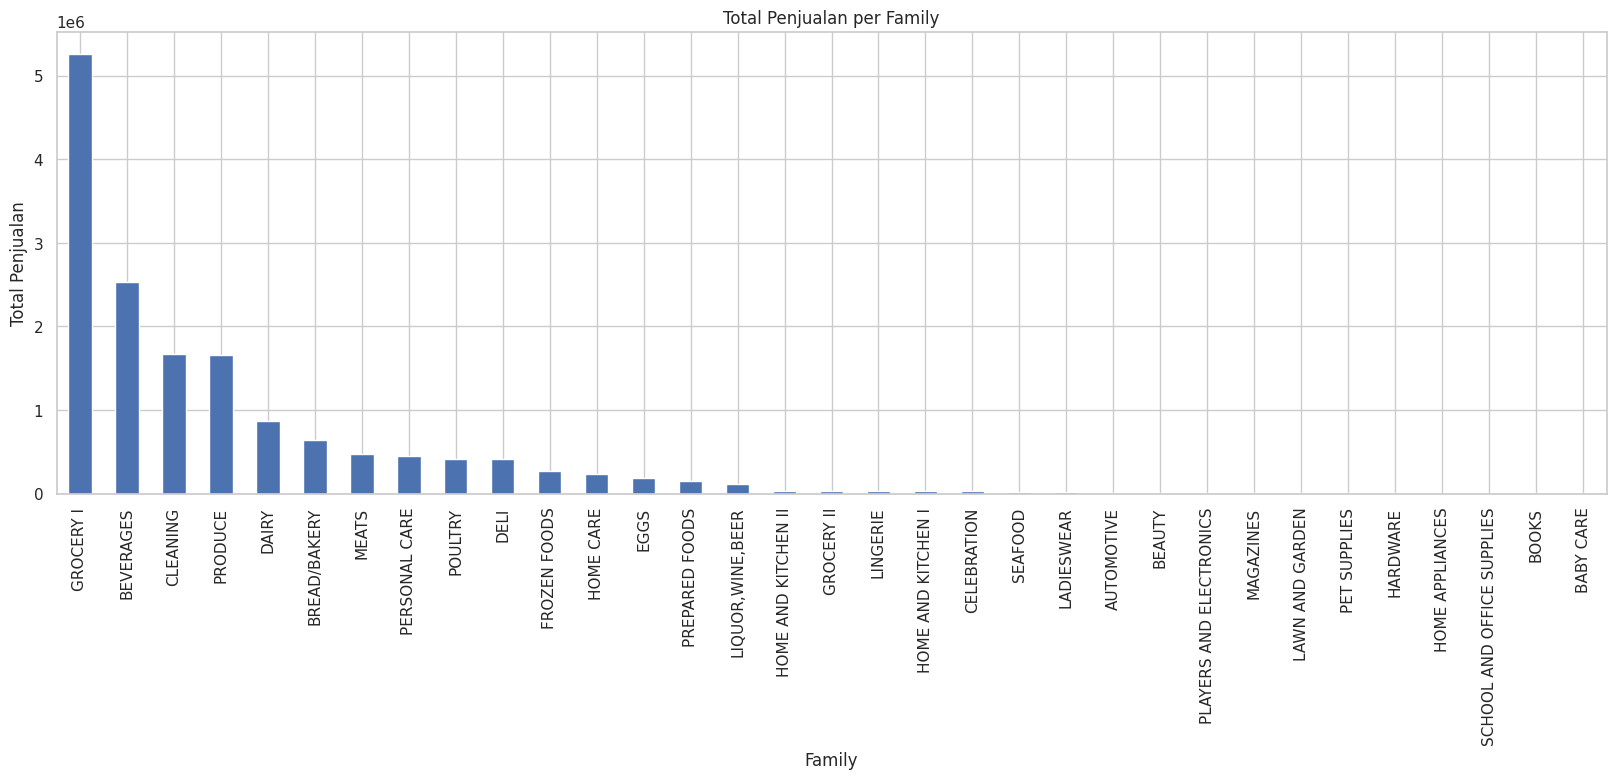

In [12]:
# plot data total penjualan berdasarkan family
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

# Gunakan fungsi groupby dan sum untuk menghitung total penjualan per family
df_train.groupby('family')['sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Penjualan per Family')
plt.xlabel('Family')
plt.ylabel('Total Penjualan')
plt.show()

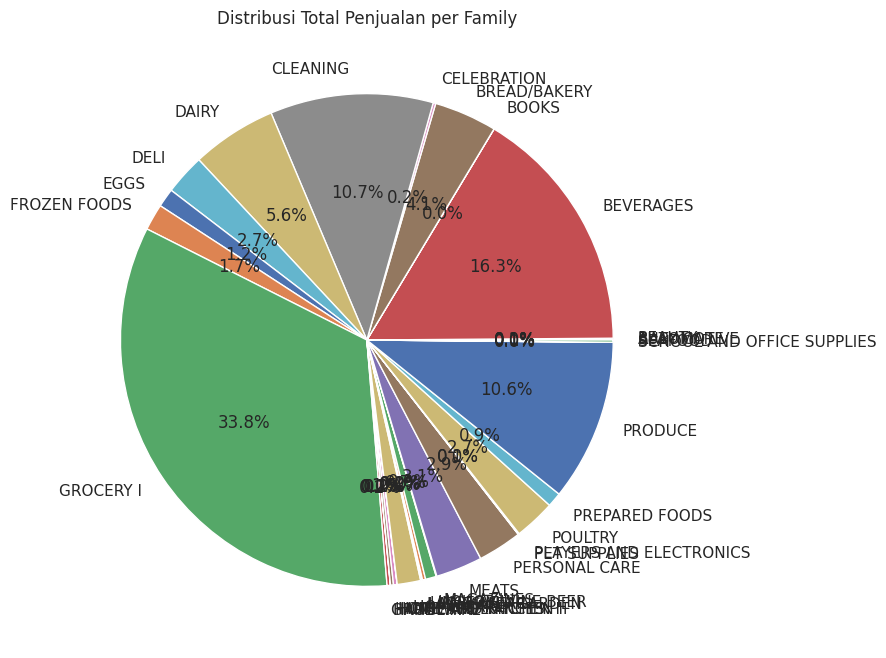

In [13]:
# Menghitung total penjualan per family
total_sales_per_family = df_train.groupby('family')['sales'].sum()

# Membuat pie chart
plt.figure(figsize=(10, 8))
total_sales_per_family.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribusi Total Penjualan per Family')
plt.ylabel('')  # Menghilangkan label y-axis karena tidak diperlukan di pie chart
plt.show()

## EDA (School and Office Supplies)

In [16]:
school = df_train['family']=='SCHOOL AND OFFICE SUPPLIES'
school = df_train[school]
school

,family,sales
date,,
2013-01-01,SCHOOL AND OFFICE SUPPLIES,0.0
2013-01-02,SCHOOL AND OFFICE SUPPLIES,0.0
2013-01-03,SCHOOL AND OFFICE SUPPLIES,0.0
2013-01-04,SCHOOL AND OFFICE SUPPLIES,0.0
2013-01-05,SCHOOL AND OFFICE SUPPLIES,0.0
...,...,...
2017-08-11,SCHOOL AND OFFICE SUPPLIES,1.0
2017-08-12,SCHOOL AND OFFICE SUPPLIES,3.0
2017-08-13,SCHOOL AND OFFICE SUPPLIES,1.0


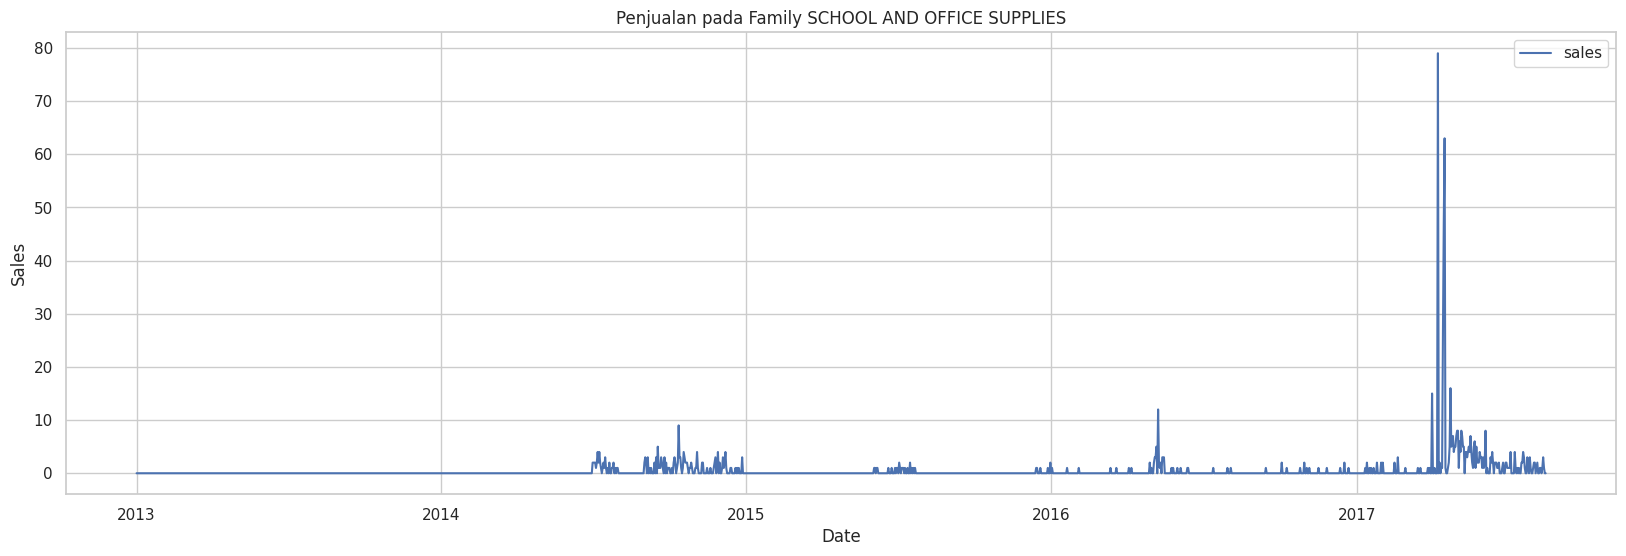

In [17]:
# Melihat penjualan pada family SCHOOL AND OFFICE SUPPLIES
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=school, x='date', y='sales', label='sales')
plt.title('Penjualan pada Family SCHOOL AND OFFICE SUPPLIES')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<Axes: xlabel='date'>

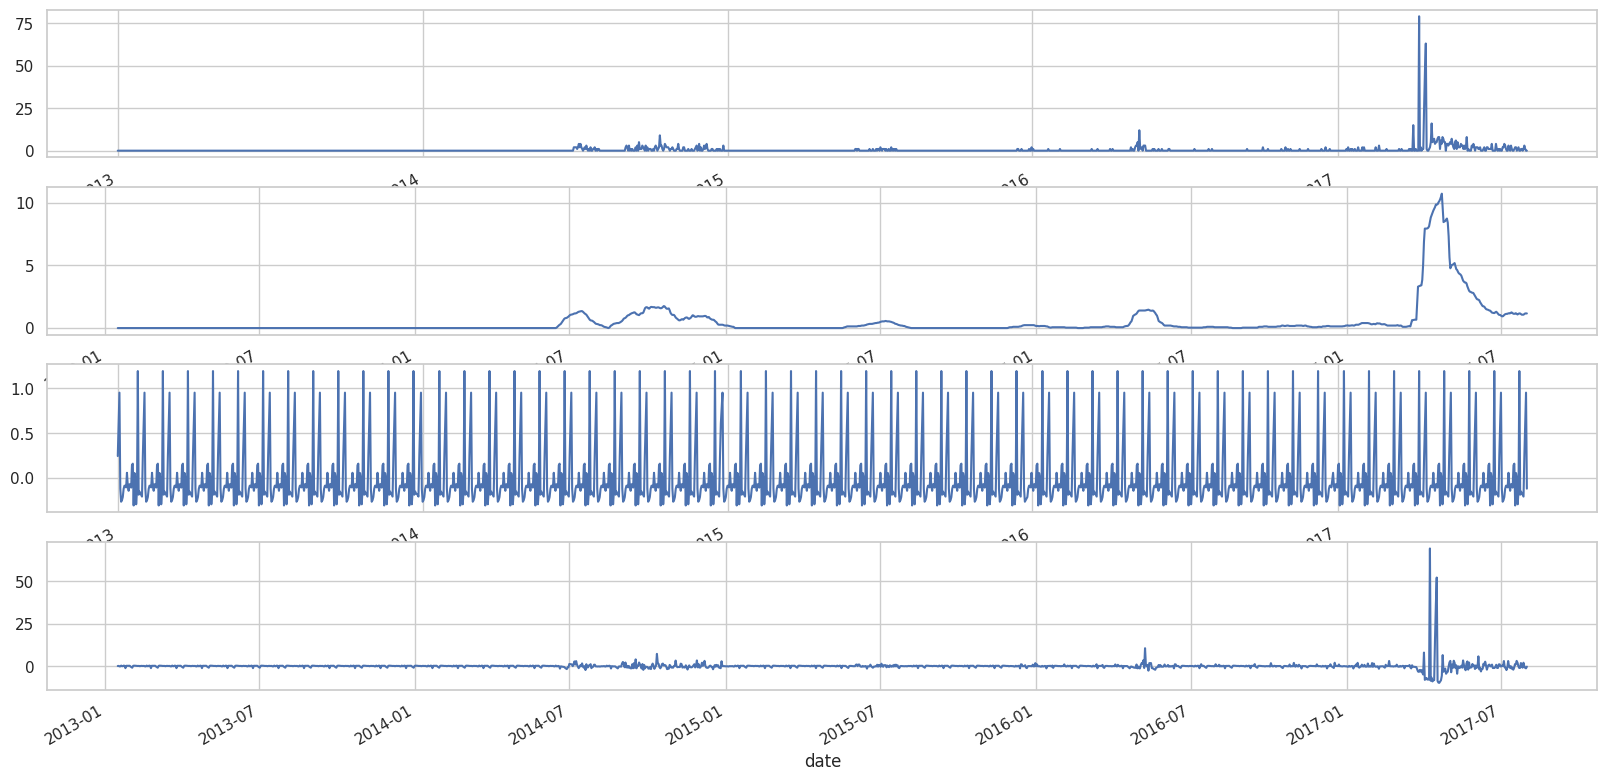

In [18]:
# Decompose data transactions
plot_decompose = seasonal_decompose(school['sales'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1)
plot_decompose.trend.plot(ax=ax2)
plot_decompose.seasonal.plot(ax=ax3)
plot_decompose.resid.plot(ax=ax4)

In [19]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(school['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.825062
p-value: 0.000049


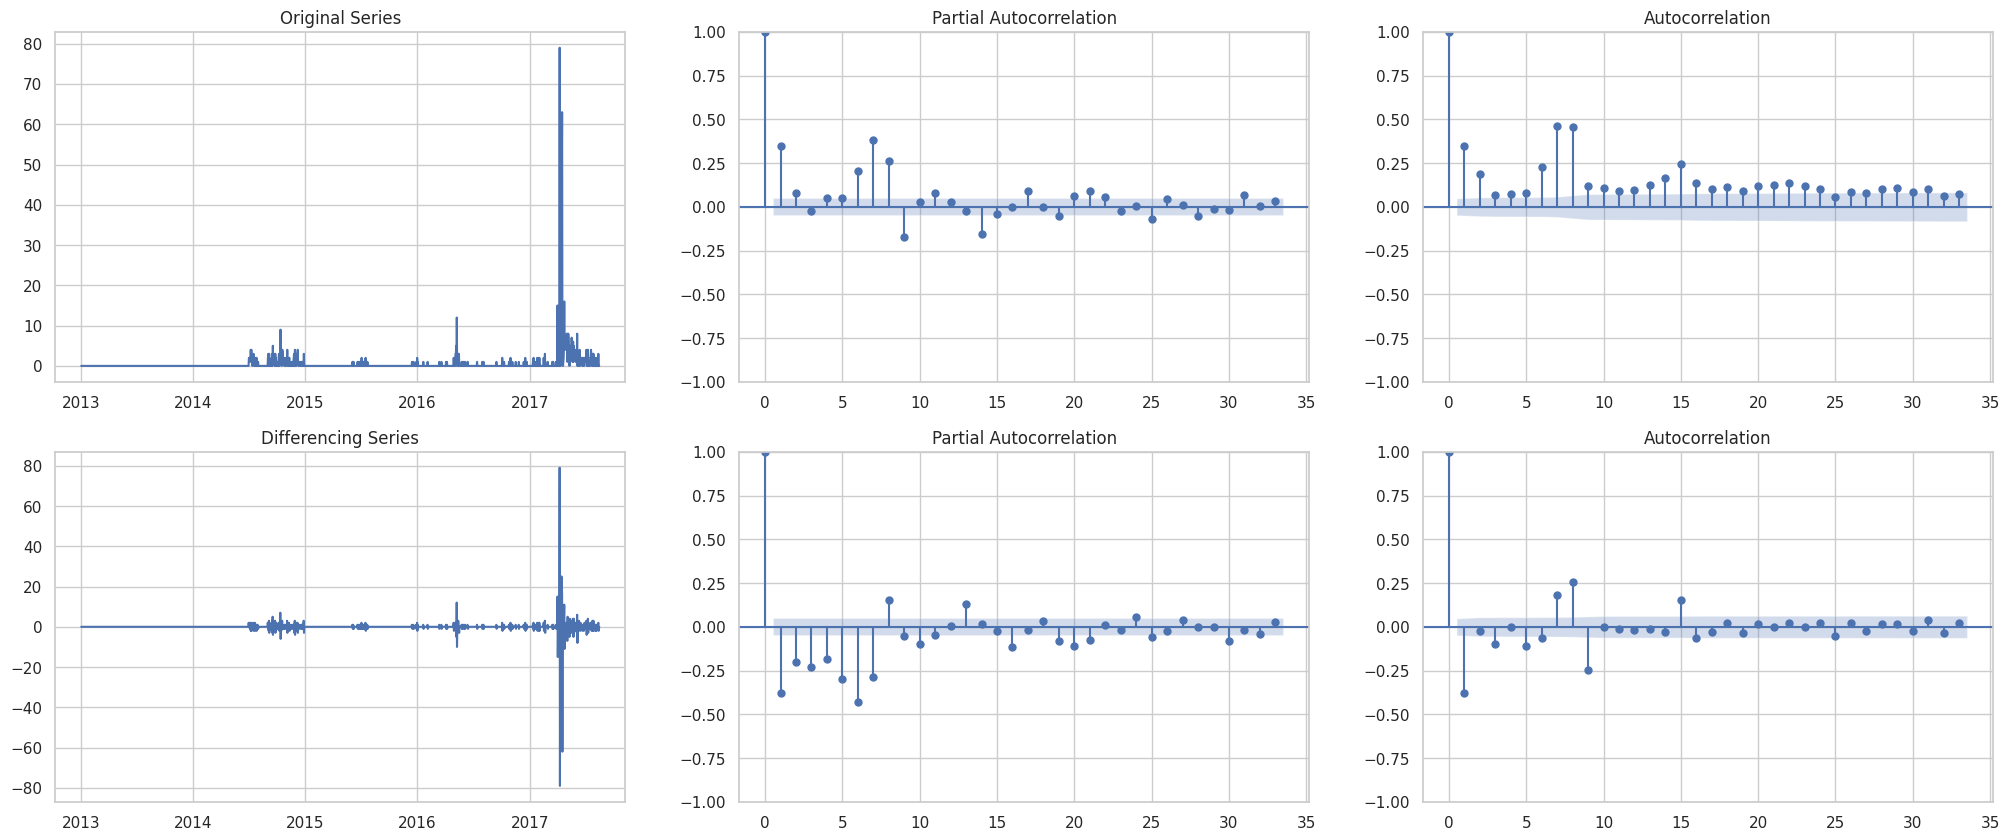

In [20]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(school['sales'])
ax[0, 1] = plot_pacf(school['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(school['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(school['sales'].diff().dropna())
ax[1, 1] = plot_pacf(school['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(school['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

## Feature Engineering

In [21]:
# Membagi fitur tanggal menjadi tahun, bulan, dan hari
school = school.copy()
school.loc[:, 'year'] = school.index.year
school.loc[:, 'month'] = school.index.month
school.loc[:, 'day'] = school.index.day
school.loc[:, 'dayofweek'] = school.index.dayofweek
school

,family,sales,year,month,day,dayofweek
date,,,,,,
2013-01-01,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,1,1
2013-01-02,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,2,2
2013-01-03,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,3,3
2013-01-04,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,4,4
2013-01-05,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,5,5
...,...,...,...,...,...,...
2017-08-11,SCHOOL AND OFFICE SUPPLIES,1.0,2017,8,11,4
2017-08-12,SCHOOL AND OFFICE SUPPLIES,3.0,2017,8,12,5
2017-08-13,SCHOOL AND OFFICE SUPPLIES,1.0,2017,8,13,6


In [22]:
# Menambahkan rolling window mean pada sales sepanjang 7 hari
school['sales_mean_7'] = school['sales'].rolling(window=7).mean()
# Menambahkan rolling window mean pada sales sepanjang 30 hari
school['sales_mean_30'] = school['sales'].rolling(window=30).mean()
school

,family,sales,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,
2013-01-01,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,1,1,NaN,NaN
2013-01-02,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,2,2,NaN,NaN
2013-01-03,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,3,3,NaN,NaN
2013-01-04,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,4,4,NaN,NaN
2013-01-05,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...
2017-08-11,SCHOOL AND OFFICE SUPPLIES,1.0,2017,8,11,4,0.714286,1.066667
2017-08-12,SCHOOL AND OFFICE SUPPLIES,3.0,2017,8,12,5,0.857143,1.166667
2017-08-13,SCHOOL AND OFFICE SUPPLIES,1.0,2017,8,13,6,1.000000,1.166667


In [25]:
# Split data menjadi data training dan data testing
train = school[:-30]
test = school[-30:]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1654, 8)
Test shape: (30, 8)


# Model

### Arima

In [46]:
# ARIMA
model_arima = ARIMA(train['sales'], order=(1, 0, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1654
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4066.749
Date:                Sat, 16 Mar 2024   AIC                           8141.499
Time:                        04:56:32   BIC                           8163.143
Sample:                             0   HQIC                          8149.522
                               - 1654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4698      0.311      1.511      0.131      -0.139       1.079
ar.L1          0.5325      0.018     29.615      0.000       0.497       0.568
ma.L1         -0.2139      0.020    -10.630      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


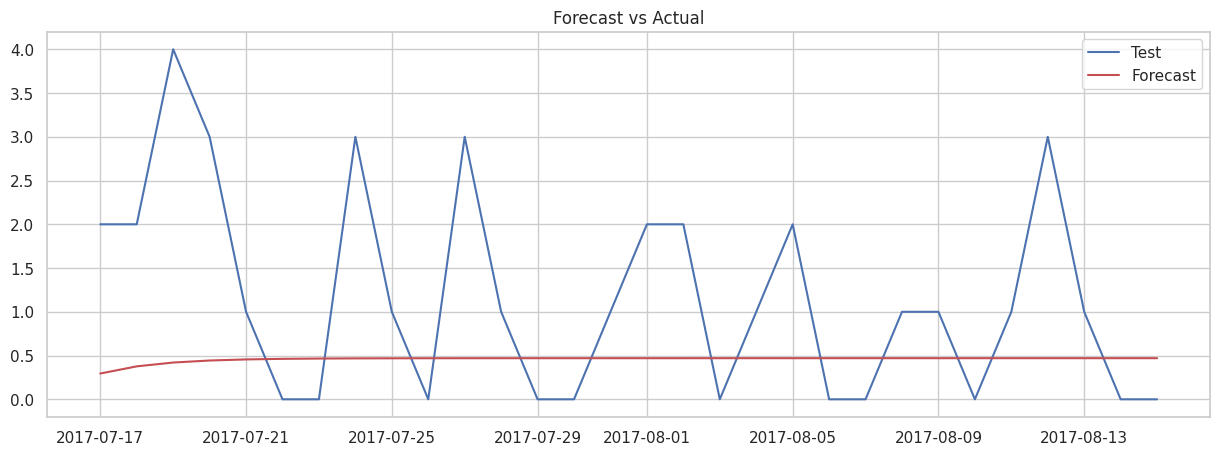

In [27]:
# Prediction
forecast = model_arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [50]:
# check forecast row
forecastARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastARIMA

,test,forecast
date,,
2017-07-17,2.0,0.661169
2017-07-18,2.0,-0.178811
2017-07-19,4.0,0.878328
2017-07-20,3.0,0.484385
2017-07-21,1.0,0.839458
2017-07-22,0.0,0.413777
2017-07-23,0.0,-0.146757
2017-07-24,3.0,0.548984
2017-07-25,1.0,0.489935


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## LSTM

In [31]:
school

,family,sales,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,
2013-01-01,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,1,1,NaN,NaN
2013-01-02,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,2,2,NaN,NaN
2013-01-03,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,3,3,NaN,NaN
2013-01-04,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,4,4,NaN,NaN
2013-01-05,SCHOOL AND OFFICE SUPPLIES,0.0,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...
2017-08-11,SCHOOL AND OFFICE SUPPLIES,1.0,2017,8,11,4,0.714286,1.066667
2017-08-12,SCHOOL AND OFFICE SUPPLIES,3.0,2017,8,12,5,0.857143,1.166667
2017-08-13,SCHOOL AND OFFICE SUPPLIES,1.0,2017,8,13,6,1.000000,1.166667


In [33]:
# Forward fill for missing values
school.fillna(method='ffill', inplace=True)

In [56]:
# Normalize grocery
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(school[['sales']].values)

In [35]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [38]:
from sklearn.model_selection import train_test_split
look_back = 1  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, look_back)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [39]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [40]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
predictions = model.predict(X_test)

# Invert predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

Epoch 1/50
43/43 [==============================] - 13s 7ms/step - loss: 8.5636e-05
Epoch 2/50
43/43 [==============================] - 0s 6ms/step - loss: 8.9127e-05
Epoch 3/50
43/43 [==============================] - 0s 7ms/step - loss: 8.2152e-05
Epoch 4/50
43/43 [==============================] - 0s 7ms/step - loss: 8.0795e-05
Epoch 5/50
43/43 [==============================] - 0s 7ms/step - loss: 8.1081e-05
Epoch 6/50
43/43 [==============================] - 0s 6ms/step - loss: 7.8120e-05
Epoch 7/50
43/43 [==============================] - 0s 6ms/step - loss: 7.3925e-05
Epoch 8/50
43/43 [==============================] - 0s 7ms/step - loss: 7.3242e-05
Epoch 9/50
43/43 [==============================] - 0s 6ms/step - loss: 7.2987e-05
Epoch 10/50
43/43 [==============================] - 0s 6ms/step - loss: 7.1131e-05
Epoch 11/50
43/43 [==============================] - 0s 7ms/step - loss: 7.2319e-05
Epoch 12/50
43/43 [==============================] - 0s 7ms/step - loss: 7.5962e-05


In [43]:
# Ensure both predictions and y_test are flattened (1D arrays) to avoid shape mismatch
predictions_flattened = predictions.flatten()
y_test_flattened = y_test.flatten()  # Assuming y_test was inversely transformed to a 2D array

In [44]:
from sklearn.metrics import r2_score

# Assume predictions and y_test are already defined as they were before

# Calculate Mean Squared Error (MSE)
mse = np.mean((predictions - y_test) ** 2)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(predictions - y_test))

# Calculate the R^2 score
r2 = r2_score(y_test_flattened, predictions_flattened)

# Print the errors
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 46.90107582723305
Root Mean Squared Error (RMSE): 6.848436013224702
Mean Absolute Error (MAE): 2.0036557112263558
R^2 Score: 0.09399758153571303


In [53]:
# Input into pandas dataframe, test as index and plot_predicted as the column
# Reshape the data plot_predicted
plot_predicted = plot_predicted.reshape(30,)

forecastLSTM = pd.DataFrame({'test': test['sales'], 'forecast': plot_predicted}, index=test.index)
forecastLSTM

NameError: name 'plot_predicted' is not defined

## SARIMA

In [45]:
# Seasonal ARIMA (SARIMA)
model_sarima = ARIMA(train['sales'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3927.544
Date:                         Sat, 16 Mar 2024   AIC                           7867.089
Time:                                 04:56:29   BIC                           7899.554
Sample:                                      0   HQIC                          7879.124
                                        - 1654                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4661      0.923      0.505      0.614      -1.343       2.276
ar.L1          0.9673      0.010     99.974      0.000     

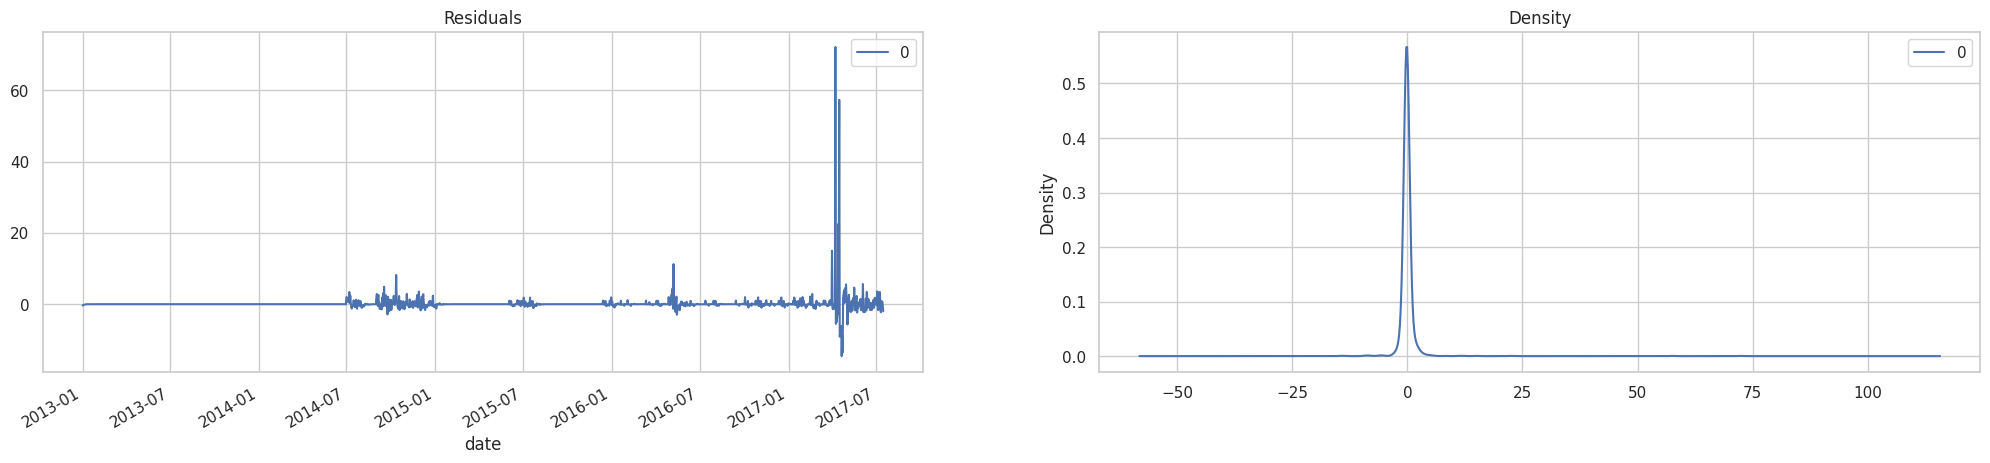

In [47]:
# Plot residual errors
residuals = pd.DataFrame(model_sarima_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


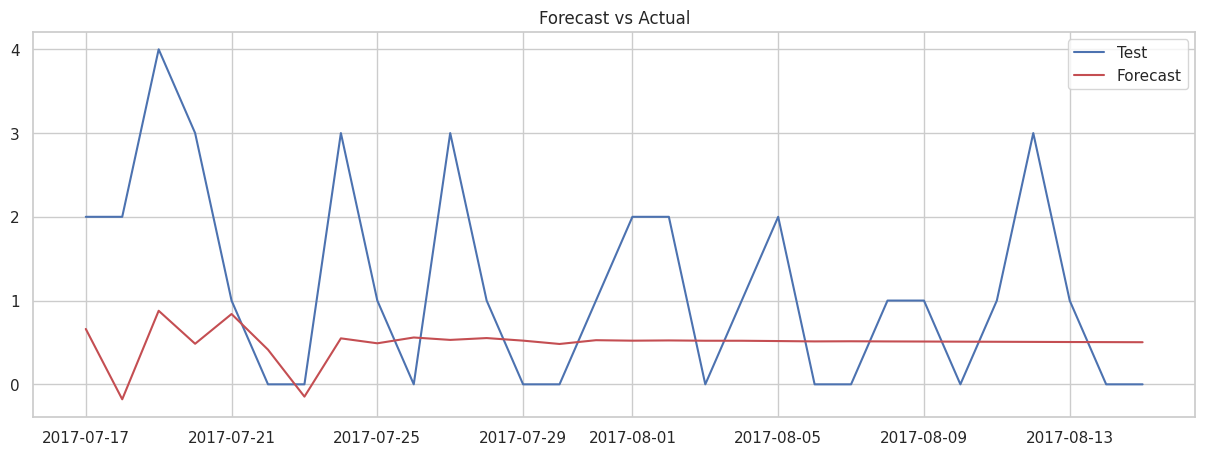

In [48]:
# Prediction
forecast = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [49]:
# check forecast row
forecastSARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMA

,test,forecast
date,,
2017-07-17,2.0,0.661169
2017-07-18,2.0,-0.178811
2017-07-19,4.0,0.878328
2017-07-20,3.0,0.484385
2017-07-21,1.0,0.839458
2017-07-22,0.0,0.413777
2017-07-23,0.0,-0.146757
2017-07-24,3.0,0.548984
2017-07-25,1.0,0.489935


# Uji Metrik

In [57]:
model = [forecastSARIMA, forecastARIMA]
model_name = ['SARIMAX', 'SARIMA']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

,MAE,MSE,R2
SARIMAX,1.007595,1.73265,-0.294095
SARIMA,1.007595,1.73265,-0.294095
